#Descargando el dataset

In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from datasets import load_dataset
ds = load_dataset("Bingsu/Cat_and_Dog")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Bingsu___parquet/Bingsu--Cat_and_Dog-350a64dea4e753f9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

#Analizando el Dataset

In [ ]:
ds

DatasetDict({
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8000
    })
})

In [ ]:
ds['train']

Dataset({
    features: ['image', 'labels'],
    num_rows: 8000
})

In [ ]:
ds['test'][301]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x374 at 0x7FB01FA17C40>,
 'labels': 0}

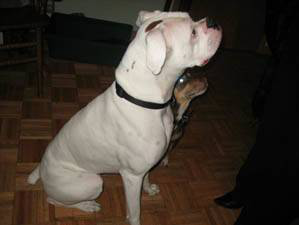

In [ ]:
ex = ds['train'][5000]
image = ex['image']
image

In [ ]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['cat', 'dog'], id=None)

In [ ]:
labels.names

['cat', 'dog']

In [ ]:
ex['labels']

1

In [ ]:
labels.int2str(ex['labels'])

'dog'

#Cargando el ViT (VisionTransformer) Feature Extractor

Prepararemos estas imágenes para nuestro modelo.

Cuando se entrenan los modelos ViT se aplican transformaciones específicas a las imágenes que se les alimentan. Si usa las transformaciones incorrectas en su imagen, el modelo no entenderá lo que está viendo. 🖼 ➡️

Para asegurarnos de que aplicamos las transformaciones correctas, usaremos un `ViTFeatureExtractor` inicializado con una configuración que se guardó junto con el modelo pre-entrenado que planeamos usar. En nuestro caso usaremos el modelo `openai/clip-vit-large-patch14', así que carguemos su deacture extractor desde el Hub.

Un extractor de características se encarga de preparar las características de los inputs de un modelo.


In [ ]:
from transformers import ViTFeatureExtractor

repo_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
print(feature_extractor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Para procesar una imagen, simplemente pásala a la función `call` del extractor. Esto devolverá un diccionario que contiene valores de pixeles, que es la representación numérica que se pasará al modelo.

De forma determinada obtenemos una matriz NumPy, pero si agregamos el argumento `return_tensors='pt'`, obtendremos tensores de PyTorch en su lugar.

In [ ]:
feature_extractor(image,return_tensors = 'pt')

{'pixel_values': tensor([[[[-0.8980, -0.8824, -0.8745,  ..., -0.9765, -0.9765, -0.9765],
          [-0.8902, -0.8745, -0.8667,  ..., -0.9686, -0.9765, -0.9765],
          [-0.8824, -0.8667, -0.8588,  ..., -0.9765, -0.9843, -0.9843],
          ...,
          [-0.4431, -0.4275, -0.4196,  ..., -0.8980, -0.9059, -0.9059],
          [-0.4588, -0.4353, -0.4353,  ..., -0.9059, -0.9137, -0.9059],
          [-0.4431, -0.4275, -0.4196,  ..., -0.8980, -0.8980, -0.8980]],

         [[-0.8980, -0.8824, -0.8745,  ..., -0.9765, -0.9765, -0.9765],
          [-0.8902, -0.8745, -0.8667,  ..., -0.9686, -0.9765, -0.9765],
          [-0.8824, -0.8667, -0.8588,  ..., -0.9765, -0.9843, -0.9843],
          ...,
          [-0.6392, -0.6235, -0.6157,  ..., -0.8980, -0.9059, -0.9059],
          [-0.6549, -0.6314, -0.6314,  ..., -0.9059, -0.9137, -0.9059],
          [-0.6392, -0.6235, -0.6157,  ..., -0.8980, -0.8980, -0.8980]],

         [[-0.9137, -0.8980, -0.8902,  ..., -0.9765, -0.9765, -0.9765],
          [-0

In [ ]:
feature_extractor(image,return_tensors = 'pt')['pixel_values'].shape

torch.Size([1, 3, 224, 224])

### Procesando el dataset

Ahora podemos leer imágenes y transformarlas en inputs para nuestro modelo. Escribamos una función que juntará esos dos pasos. Recuerda que `feature_extractor` retorna un diccionario con la key `pixel_values`. Le sumamos una segunda key con las etiquetas `labels`.

In [ ]:
def process_example(example):
  inputs = feature_extractor(image,return_tensors = 'pt') #que devuelva un tensor de pytorch
  inputs['labels'] = example['labels']
  return inputs

Así se ve un ejemplo procesado de esta manera.

In [ ]:
process_example(ds['train'][5000])

{'pixel_values': tensor([[[[-0.8980, -0.8824, -0.8745,  ..., -0.9765, -0.9765, -0.9765],
          [-0.8902, -0.8745, -0.8667,  ..., -0.9686, -0.9765, -0.9765],
          [-0.8824, -0.8667, -0.8588,  ..., -0.9765, -0.9843, -0.9843],
          ...,
          [-0.4431, -0.4275, -0.4196,  ..., -0.8980, -0.9059, -0.9059],
          [-0.4588, -0.4353, -0.4353,  ..., -0.9059, -0.9137, -0.9059],
          [-0.4431, -0.4275, -0.4196,  ..., -0.8980, -0.8980, -0.8980]],

         [[-0.8980, -0.8824, -0.8745,  ..., -0.9765, -0.9765, -0.9765],
          [-0.8902, -0.8745, -0.8667,  ..., -0.9686, -0.9765, -0.9765],
          [-0.8824, -0.8667, -0.8588,  ..., -0.9765, -0.9843, -0.9843],
          ...,
          [-0.6392, -0.6235, -0.6157,  ..., -0.8980, -0.9059, -0.9059],
          [-0.6549, -0.6314, -0.6314,  ..., -0.9059, -0.9137, -0.9059],
          [-0.6392, -0.6235, -0.6157,  ..., -0.8980, -0.8980, -0.8980]],

         [[-0.9137, -0.8980, -0.8902,  ..., -0.9765, -0.9765, -0.9765],
          [-0

Podemos llamar a la función `map` y aplicar esto a todos los ejemplos a la vez. Pero esto puede ser muy lento, especialmente si usa un dataset más grande. 

Entonces podemos aplicar una ***transformación*** al dataset. Las transformaciones solo se aplican a los ejemplos a medida que los indexamos.

Sin embargo, primero deberá actualizar la última función para aceptar un batch posiblemente con más de una imagen, ya que eso es lo que espera `ds.with_transform`.

In [ ]:
def transform(example_batch):
  inputs = feature_extractor([x for x in example_batch['image']], return_tensors = 'pt')
  inputs['labels'] = example_batch['labels']
  return inputs

Puedes aplicar esto directamente al dataset mediante `ds.with_transform(transform)`

In [ ]:
prepared_ds = ds.with_transform(transform)

Ahora, cada vez que obtengas un ejemplo del dataset, la transformación se aplicará en tiempo real.

In [ ]:
prepared_ds['train'][:2]['pixel_values']

tensor([[[[-0.6941, -0.6863, -0.6784,  ...,  0.6157,  0.6000,  0.5686],
          [-0.6863, -0.6863, -0.6784,  ...,  0.5843,  0.5686,  0.5529],
          [-0.6941, -0.6941, -0.7020,  ...,  0.5451,  0.5608,  0.5765],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.6627, -0.6863, -0.6157],
          [-0.7569, -0.7804, -0.8196,  ..., -0.6941, -0.6706, -0.5922],
          [-0.7569, -0.7882, -0.8275,  ..., -0.5843, -0.6314, -0.6549]],

         [[-0.6549, -0.6549, -0.6471,  ...,  0.6000,  0.5765,  0.5529],
          [-0.6471, -0.6549, -0.6471,  ...,  0.5529,  0.5451,  0.5294],
          [-0.6549, -0.6627, -0.6706,  ...,  0.5137,  0.5294,  0.5451],
          ...,
          [-0.7882, -0.8039, -0.8353,  ..., -0.7725, -0.7882, -0.7020],
          [-0.7725, -0.7961, -0.8353,  ..., -0.7961, -0.7725, -0.6784],
          [-0.7725, -0.8039, -0.8431,  ..., -0.6863, -0.7333, -0.7412]],

         [[-0.6863, -0.6706, -0.6471,  ...,  0.3804,  0.3098,  0.2627],
          [-0.6784, -0.6706, -

In [ ]:
prepared_ds['train'][:2]['pixel_values'].shape

torch.Size([2, 3, 224, 224])

El tensor `pixel_values` ​​resultante tendrá forma (2, 3, 224, 224) porque pasamos un batch de dos ejemplos.

### Definiendo el data collator


Los data collators, o recopiladores de datos, son objetos que forman batches utilizando una lista de ejemplos de nuestros datasets. Para poder generar los batches, los data collators pueden aplicar algún procesamiento (como padding en los ejemplos con texto).

Definimos una función, `collate_fn`, que fungirá como nuestro data collator. Devolverá un diccionario por cada batch. Recibirá un batch de datos que luego serán procesadas.

Los batches llegan como listas de dicts. Cada dict tiene los `label` y `pixel_values` de sus respectivos ejemplos, por lo que puedes simplemente desempaquetarlos y apilarlos en tensores de batches. `torch.stack` nos permite concatenar (pegar) tensores.


In [ ]:
import torch

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

In [ ]:
a = torch.tensor([0,1,2])
b = torch.tensor([3,4,5])
torch.stack((a,b))

tensor([[0, 1, 2],
        [3, 4, 5]])

### Definiendo la métrica 

De la biblioteca `Datasets` también podemos cargar métricas. `accuracy` se puede usar fácilmente para comparar las predicciones con las etiquetas originales.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric('accuracy')

def compute_metrics(prediction):
  return metric.compute(predictions=np.argmax(prediction.predictions,axis=1), references=prediction.label_ids)

<ipython-input-25-97c8825dc997>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co./docs/evaluate
  metric = load_metric('accuracy')


### Configurando `Trainer`

Carguemos el modelo preentrenado. Agregaremos `num_labels` para que el modelo cree un encabezado de clasificación con el número correcto de etiquetas. También incluiremos las asignaciones `id2label` y `label2id` para tener etiquetas legibles por humanos en el widget del Hub.

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels = len(labels),
    id2label={str(i): c for i,c in enumerate(labels)},
    label2id = { c: str(i) for i,c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Lo último que se necesita antes de eso es establecer la configuración de entrenamiento definiendo `TrainingArguments`.

La mayoría de estos se explican por sí mismos, pero uno que es bastante importante aquí es `remove_unused_columns=False`. Este eliminará cualquier función que no utilice la función de llamada del modelo. De forma predeterminada es True porque, por lo general, es ideal eliminar las columnas de funciones no utilizadas, lo que facilita el desempaquetado de las entradas en la función de llamada del modelo. Pero, en nuestro caso, necesitamos las funciones no utilizadas ('imagen' en particular) para crear '`pixel_values`'.

In [ ]:
from transformers import TrainingArguments

#Ver la documentación
training_args = TrainingArguments(
    output_dir="./PerrosVSgatos_google/vit-base-patch16-224-in21k",
    evaluation_strategy='steps',
    num_train_epochs=4,
    learning_rate=2e-4,
    push_to_hub=True,
    remove_unused_columns=False,
    load_best_model_at_end=True
)

In [ ]:
!git config --global credential.helper store
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co./settings/tokens .
    
Token: 
Add token as git credential? (Y/n) 
Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    train_dataset = prepared_ds['train'],
    eval_dataset = prepared_ds['test'],
    tokenizer = feature_extractor,
)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co./julenalvaro/vit-base-patch16-224-in21k into local empty directory.


### Entrenamiento

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics('train',train_results.metrics)
trainer.save_metrics('train',train_results.metrics)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8000
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4000
  Number of trainable parameters = 85800194


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-500
Configuration saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-500/config.json
Model weights saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-500/pytorch_model.bin
Image processor saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-500/preprocessor_config.json
Image processor saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-1000
Configuration saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-1000/config.json
Model weights saved in ./PerrosVSgatos_google/vit-base-patch16-224-in21k/checkpoint-1000/pytorch_model.bin
Image processor saved in ./PerrosVSgatos_googl

Upload file pytorch_model.bin:   0%|          | 3.30k/327M [00:00<?, ?B/s]

Upload file runs/Jan04_12-36-23_5ef0839b4006/events.out.tfevents.1672835807.5ef0839b4006.127.0:  42%|####2    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co./julenalvaro/vit-base-patch16-224-in21k
   0db1958..1df9af2  main -> main

remote: LFS file scan complete.        
To https://huggingface.co./julenalvaro/vit-base-patch16-224-in21k
   0db1958..1df9af2  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Image Classification', 'type': 'image-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.982}]}
To https://huggingface.co./julenalvaro/vit-base-patch16-224-in21k
   1df9af2..237c33f  main -> main

   1df9af2..237c33f  main -> main



***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2309441256GF
  train_loss               =       0.0582
  train_runtime            =   0:27:36.35
  train_samples_per_second =        19.32
  train_steps_per_second   =        2.415


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.975
  eval_loss               =      0.071
  eval_runtime            = 0:00:40.49
  eval_samples_per_second =     49.387
  eval_steps_per_second   =      6.173
